# Sepsis-3 evaluation in the MIMIC-III database

This notebook goes over the evaluation of the new Sepsis-3 guidelines in the MIMIC database. The goals of this analysis include:

1. Evaluating the Sepsis-3 guidelines in MIMIC using the same methodology as in the research paper
2. Evaluating the Sepsis-3 guidelines against hospital mortality
3. (Appendix) Assessing if there are interesting subgroup(s) which are missed by the criteria

Here, we define Sepsis-3 using the flowchart which reproduces that from Singer et al. (2016):

![title](img/sepsis-flow.png)

We can see that the *primary* use case of Sepsis-3 is qSOFA >= 2 followed by SOFA >= 2, but this is not required to define sepsis - only SOFA >= 2 is required (where baseline SOFA is assumed to be 0 for patients - of course this may not be the case in those with chronic organ dysfunction).

In this notebook, we define Sepsis-3 as qSOFA>=2 followed by SOFA>=2 - and this allows for an illustration of the common application of the algorithm.

In [1]:
from __future__ import print_function

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from collections import OrderedDict
from statsmodels.formula.api import logit
from IPython.display import display, HTML # used to print out pretty pandas dataframes

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru

# used to calculate AUROC/accuracy
from sklearn import metrics

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

%matplotlib inline

In [2]:
# load data
df = pd.read_csv('sepsis3-df.csv',sep=',')
df_mdl = pd.read_csv('sepsis3-design-matrix.csv',sep=',')

# define outcome
target_header = "hospital_expire_flag"
y = df[target_header].values == 1

# define the covariates to be added in the MFP model (used for table of AUROCs)
preds_header = ['sirs','qsofa','sofa','mlods']

# Hospital mortality evaluation

In [3]:
# define targets, angus critera
# define "predictions" according to the SEPSIS-3 guidelines:
#  suspicion of infection, qSOFA >= 2, and SOFA >= 2
# this was done in the SQL code - so we pull the values here
yhat = df.sepsis3.values

print('\n SEPSIS-3 guidelines for hospital mortality \n')
# generate evaluation metrics
print('Accuracy = {}'.format(metrics.accuracy_score(y, yhat)))

su.print_cm(y, yhat) # print confusion matrix


 SEPSIS-3 guidelines for hospital mortality 

Accuracy = 0.549476478396

Confusion matrix
      	y=0   	y=1   
yhat=0	  3056	   278	NPV=91.66
yhat=1	  2777	   670	PPV=19.44
   	52.39	70.68	Acc=54.95
   	Spec	Sens


Predictions using various levels of confounder adjustment are calculated in the subfunctions `calc_predictions`:

* `model=None` - the severity scores on their own
* `model='baseline'` - the severity scores in a vanilla regression
* `model='mfp'` -the severity scores in a fractional polynomial regression (calls an R script)

In [4]:
preds = su.calc_predictions(df, preds_header, target_header, model=None)
preds_logreg = su.calc_predictions(df, preds_header, target_header, model='logreg')
preds_mfp = su.calc_predictions(df, preds_header, target_header, model='mfp')

# also get the baseline performance of an MFP model without severity of illness
preds_mfp_baseline = su.calc_predictions(df, preds_header, target_header, model='mfp_baseline')

In [5]:
# reproduce the AUC table

# print out the baseline AUROC of a model without severity of illness
# in Seymour2016, this was 0.58 (validation)
auc_mfp_baseline, ci_mfp_baseline = ru.calc_auc(preds_mfp_baseline, y, with_ci=True, alpha=0.05)
print('Performance of an MFP model without severity of illness: {:0.3f} [{:0.3f}, {:0.3f}]'.format(
    auc_mfp_baseline, ci_mfp_baseline[0], ci_mfp_baseline[1]))
print('\n')

print('AUROC table for unadjusted scores:')
su.print_auc_table(preds, df[target_header].values, preds_header)
print('\n')

print('AUROC table for adjusted scores (using logistic regression):')
su.print_auc_table(preds_logreg, df[target_header].values, preds_header)
print('\n')

print('AUROC table for adjusted scores (using MFP):')
su.print_auc_table(preds_mfp, df[target_header].values, preds_header) # optional argument fixes order of output
print('\n')

su.print_auc_table_to_file(preds, df[target_header].values, preds_header=preds_header,
                           filename='auc-table-mort.csv')

su.print_auc_table_to_file(preds_mfp, df[target_header].values, preds_header=preds_header,
                           filename='auc-table-mort-mfp.csv')

Performance of an MFP model without severity of illness: 0.697 [0.679, 0.714]


AUROC table for unadjusted scores:
     	sirs                	qsofa               	sofa                	mlods               	
sirs 	0.632 [0.614, 0.649]	0.436 [0.413, 0.458]	0.179 [0.162, 0.196]	0.231 [0.211, 0.250]	
qsofa	0.191               	0.618 [0.601, 0.634]	0.271 [0.260, 0.281]	0.356 [0.344, 0.368]	
sofa 	< 0.001               	< 0.001               	0.737 [0.719, 0.755]	0.873 [0.867, 0.878]	
mlods	< 0.001               	< 0.001               	0.244               	0.744 [0.727, 0.762]	


AUROC table for adjusted scores (using logistic regression):
     	sirs                	qsofa               	sofa                	mlods               	
sirs 	0.729 [0.712, 0.746]	0.887 [0.882, 0.893]	0.709 [0.695, 0.722]	0.710 [0.696, 0.724]	
qsofa	0.043               	0.718 [0.701, 0.735]	0.764 [0.753, 0.775]	0.773 [0.761, 0.785]	
sofa 	< 0.001               	< 0.001               	0.783 [0.767, 0.799]	0.925 [0.920,

## ROC curves

### Unadjusted ROC

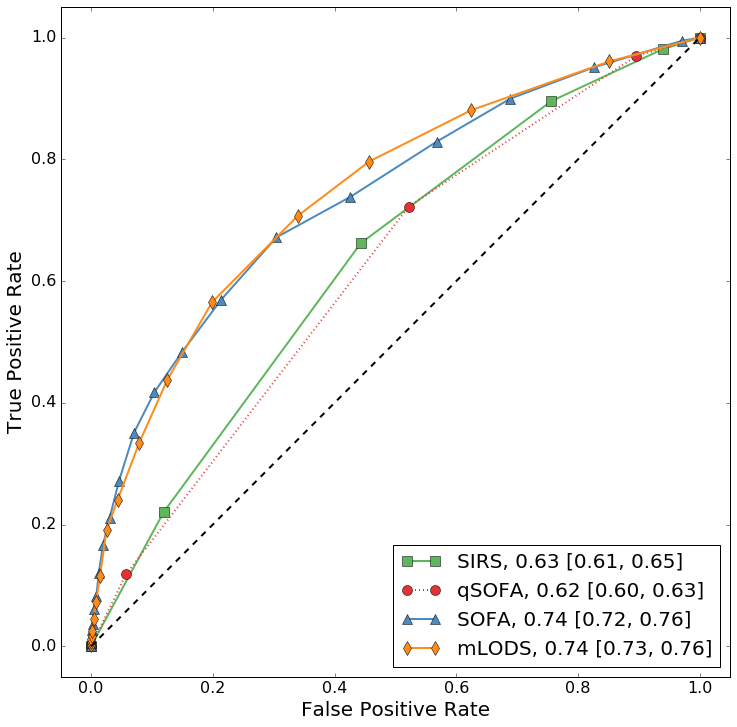

In [6]:
markers = {'qsofa': 'o:', 'sofa': '^-', 'sirs': 's-', 'mlods': 'd-'}
colors = {'qsofa': col[0], 'sofa': col[1], 'sirs': col[2], 'mlods': col[3]}
pred_pretty_text = {'qsofa': 'qSOFA', 'sofa': 'SOFA', 'sirs': 'SIRS', 'mlods': 'mLODS'}
# plot the data
ax = plt.figure(figsize=[12,12]).add_subplot(111)

# ROC for each score in preds header
for pred in preds_header:
    fpr, tpr, thr = metrics.roc_curve(y, df[pred].values)
    auc, auc_ci = ru.calc_auc(df[pred].values, y, with_ci=True, alpha=0.05)
    
    plt.plot(fpr, tpr, markers[pred],
             color=colors[pred], linewidth=2, markersize=10,
             label=pred_pretty_text[pred] + ', ' +
             '{:0.2f} [{:0.2f}, {:0.2f}]'.format(auc, auc_ci[0], auc_ci[1]))

plt.legend(loc="lower right", fontsize=20)

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)

# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
#plt.title('ROC against in-hospital mortality',fontsize=14)
plt.show()

### Scores after adjusting in MFP model

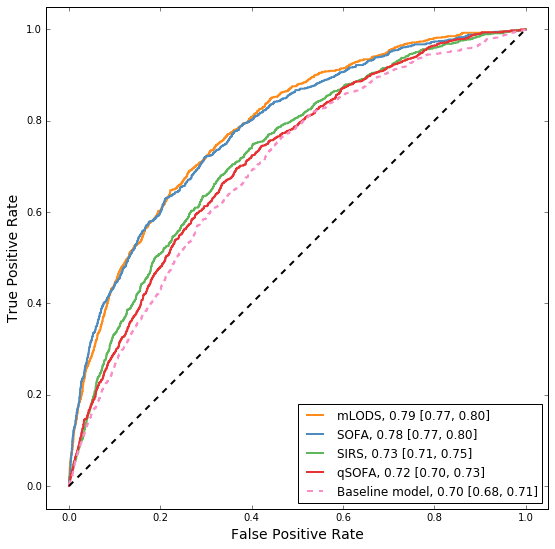

In [7]:
markers = {'qsofa': '-', 'sofa': '-', 'sirs': '-', 'mlods': '-'}
colors = {'qsofa': col[0], 'sofa': col[1], 'sirs': col[2], 'mlods': col[3]}
pred_pretty_text = OrderedDict([['mlods', 'mLODS'],
                               ['sofa', 'SOFA'],
                               ['sirs', 'SIRS'],
                               ['qsofa', 'qSOFA']])
# plot the data
plt.figure(figsize=[9,9])


# ROC for each score in preds header
for pred in pred_pretty_text:
    fpr, tpr, thr = metrics.roc_curve(y, preds_mfp[pred])
    auc, auc_ci = ru.calc_auc(preds_mfp[pred], y, with_ci=True, alpha=0.05)
    
    plt.plot(fpr, tpr, markers[pred],
             color=colors[pred], linewidth=2, markersize=10,
             label=pred_pretty_text[pred] + ', ' +
             '{:0.2f} [{:0.2f}, {:0.2f}]'.format(auc, auc_ci[0], auc_ci[1]))


# baseline MFP model
fpr, tpr, thr = metrics.roc_curve(y, preds_mfp_baseline)
auc, auc_ci = ru.calc_auc(preds_mfp_baseline, y, with_ci=True, alpha=0.05)
    
plt.plot(fpr, tpr, '--',
         color=col[6], linewidth=2, markersize=10,
         label='Baseline model, {:0.2f} [{:0.2f}, {:0.2f}]'.format(auc, auc_ci[0], auc_ci[1]))
plt.legend(loc="lower right")

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)
# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
#plt.title('ROC against in-hospital mortality',fontsize=14)
plt.show()

## Operating point statistics

This section evaluates the standard operating point statistics:

* sensitivity (% of true positives which are correctly classified)
* specificity (% of true negatives which are correctly classified)
* positive predictive value (given a positive prediction is made, what % are correct)
* negative predictive value (given a negative prediction is made, what % are correct)
* F1 score (harmonic mean of sensitivity and PPV)

In [8]:
# define "predictions" according to the SEPSIS-3 guidelines:
#  suspicion of infection, qSOFA >= 2, and SOFA >= 2
yhat_all = [df.sirs.values >= 2,
            df.qsofa.values >= 2,
            df.sofa.values >= 2,
            df.sepsis3.values,
            df.mlods.values >= 2]
yhat_names = ['SIRS', 'qsofa', 'sofa', 'seps3', 'mLODS']

# define "targets", angus critera
y_all = [y for x in yhat_names]

stats_all = su.get_op_stats(yhat_all, y_all,
               yhat_names=yhat_names,
               header=target_header)

su.print_op_stats(stats_all,
               yhat_names=yhat_names,
               header=target_header)

Metric


     	SIRS                	qsofa               	sofa                	seps3               	mLODS               
TN   	 1423           	 2788           	 1010           	 3056           	 2190           
FP   	 4410           	 3045           	 4823           	 2777           	 3643           
FN   	   99           	  263           	   46           	  278           	  113           
TP   	  849           	  685           	  902           	  670           	  835           
Sens 	89.56 [0.87, 0.91]	72.26 [0.69, 0.75]	95.15 [0.94, 0.96]	70.68 [0.68, 0.74]	88.08 [0.86, 0.90]
Spec 	24.40 [0.23, 0.26]	47.80 [0.47, 0.49]	17.32 [0.16, 0.18]	52.39 [0.51, 0.54]	37.55 [0.36, 0.39]
PPV  	16.14 [0.15, 0.17]	18.36 [0.17, 0.20]	15.76 [0.15, 0.17]	19.44 [0.18, 0.21]	18.65 [0.18, 0.20]
NPV  	93.50 [0.92, 0.95]	91.38 [0.90, 0.92]	95.64 [0.94, 0.97]	91.66 [0.91, 0.93]	95.09 [0.94, 0.96]
F1   	27.36             	29.29             	27.03             	30.49             	30.78             
NTP  	12.52